# 1) Import libraries 

In [25]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from glob import glob
from tensorflow.keras.layers import Layer

# 2) Read Image Paths

In [26]:
# data paths
ct_path = '/kaggle/input/brain-tumor-multimodal-image-ct-and-mri/Dataset/Brain Tumor CT scan Images'
mri_path = '/kaggle/input/brain-tumor-multimodal-image-ct-and-mri/Dataset/Brain Tumor MRI images'

# 3) Add all image paths to the list

In [27]:
data = []

# CT_Scan
for category in ['Tumor', 'Healthy']:
    folder = os.path.join(ct_path, category)
    label = 'Tumor' if category == 'Tumor' else 'Healthy'
    for file in glob(folder + '/*'):  # all files from folder 
        data.append((file, label, 'CT'))  # add (img path , label and source)

# MRI
for category in ['Tumor', 'Healthy']:
    folder = os.path.join(mri_path, category)
    label = 'Tumor' if category == 'Tumor' else 'Healthy'
    for file in glob(folder + '/*'):  # all files from folder
        data.append((file, label, 'MRI')) # add (img path , label and source)

# 4) Show Some images

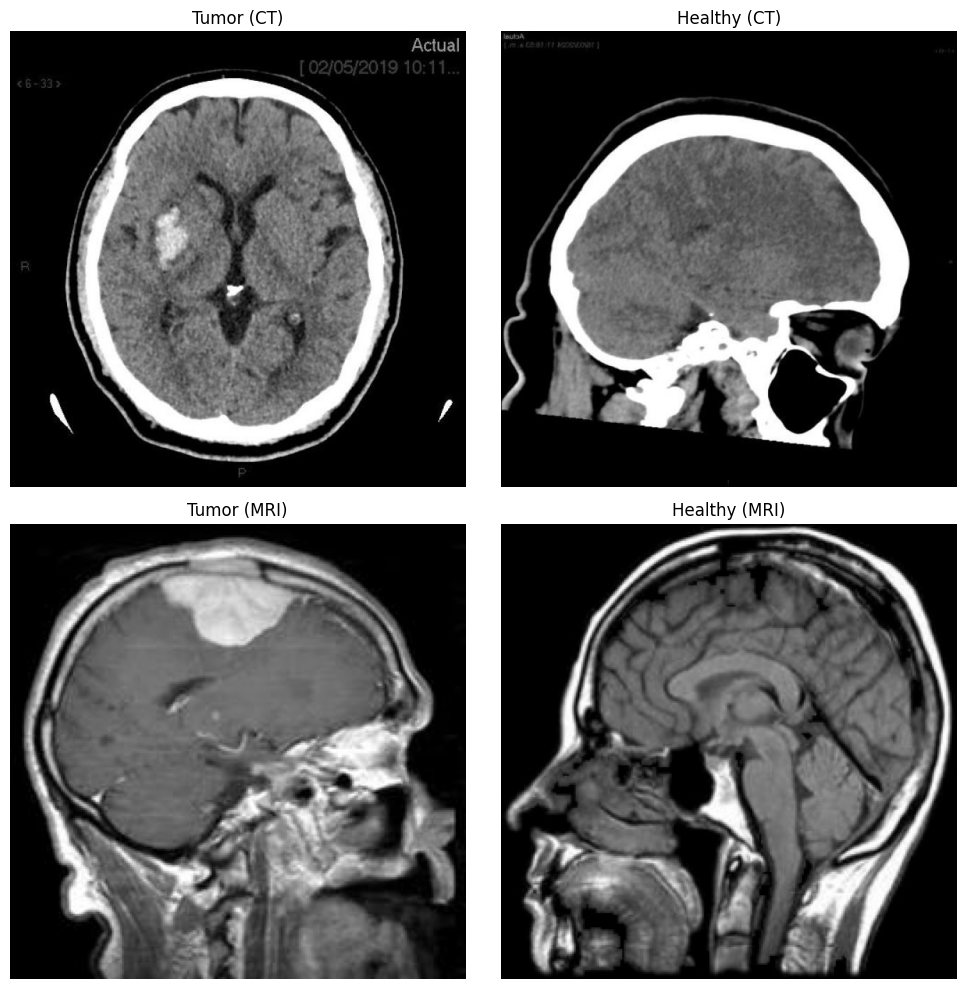

In [29]:
# some images
ct_patient = next(item for item in data if item[1] == 'Tumor' and item[2] == 'CT')  # Tumor from CT
ct_healthy = next(item for item in data if item[1] == 'Healthy' and item[2] == 'CT')  # Healthy from CT
mri_patient = next(item for item in data if item[1] == 'Tumor' and item[2] == 'MRI')  # Tumor from MRI
mri_healthy = next(item for item in data if item[1] == 'Healthy' and item[2] == 'MRI')  # Healthy from MRI

# add iamges to list
selected_images = [ct_patient, ct_healthy, mri_patient, mri_healthy]

# set figure size 
plt.figure(figsize=(10, 10))  

# plot the images
for i, (path, label, source) in enumerate(selected_images):
    img = cv2.imread(path)  
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
    plt.subplot(2, 2, i + 1)  
    plt.imshow(img)
    plt.title(f"{label} ({source})") 
    plt.axis('off') 

plt.tight_layout() 
plt.show()

# 5) Convert the data to array

In [30]:
# conert data to array
image_paths = [item[0] for item in data]
labels = [item[1] for item in data]
sources = [item[2] for item in data]

# convert labels to numbers 
label_map = {'Tumor': 1, 'Healthy': 0}
labels = np.array([label_map[label] for label in labels])

# 6) Split the data

In [31]:
# split the data
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

# 7) Read all the images into np arrays

In [32]:
def generate_images(image_paths, labels, target_size=(224, 224)):
    images = []
    processed_labels = []

    for img_path, label in zip(image_paths, labels):
        # Load and process each image
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = img/255.0
        images.append(img)
        processed_labels.append(label)

    # Convert lists to arrays
    images = np.array(images, dtype=np.float32)
    processed_labels = np.array(processed_labels, dtype=np.int32)

    return images, processed_labels


# 8) Load the data as tensorflow dataset

In [33]:
# Load and process the data
train_images, train_labels = generate_images(train_paths, train_labels, target_size=(224, 224))
val_images, val_labels = generate_images(val_paths, val_labels, target_size=(224, 224))

In [34]:
def augment_data(image, label):
    # Apply random augmentations
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, label


In [35]:
# Create tf.data.Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(64)
augmented_train_dataset = train_dataset.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)
augmented_train_dataset = augmented_train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).batch(64)

# 9) Count the number of batches in both train and test dataset

In [36]:
# count batches
def count_elements(dataset):
    return sum(1 for _ in dataset)

num_batches = count_elements(train_dataset)
print(f"Number of train batches: {num_batches}")
print(f"Number of test batches: {count_elements(val_dataset)} ")


Number of train batches: 121
Number of test batches: 31 


# 10) Detect GPU and initialize

In [37]:
# Detect hardware
try:
   # If you have *different* GPUs in your system, you probably have to set up cross_device_ops like this
   strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())
   print ('Number of devices: {}'.format(strategy.num_replicas_in_sync))

except ValueError:
  print('GPU failed to initialize.')

Number of devices: 2


# 11) Initialize Batch Size per Replica and Global Batch size

In [38]:
BATCH_SIZE_PER_REPLICA = 64
GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

# 12) Define Custom Simple Dense Layer

In [39]:
# inherit Layer class
class SimpleDense(Layer):

    def __init__(self,units=32):
        super(SimpleDense, self).__init__()
        self.units = units
    def build(self, input_shape):
      with tf.init_scope():  
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(name="kernel",
                             initial_value=w_init(shape =(input_shape[-1],self.units),
                                                 dtype='float32'),trainable = True)

        b_init = tf.zeros_initializer()
        self.b = tf.Variable(name="bias",
                            initial_value=b_init(shape=(self.units,),
                                                 dtype='float32'),trainable = True)

    def call(self, inputs):
        return tf.matmul(inputs,self.w) + self.b
 

# 13) Define Custom Identity Block for Resnet

In [40]:
class IdentityBlock(tf.keras.Model):
    def __init__(self,filters,kernel_size):
        super(IdentityBlock,self).__init__(name='')
        
        self.conv1 = tf.keras.layers.Conv2D(filters, kernel_size, padding = 'same',kernel_regularizer=tf.keras.regularizers.l2(0.1))
        self.bn1 = tf.keras.layers.BatchNormalization()

        self.conv2 = tf.keras.layers.Conv2D(filters, kernel_size, padding = 'same',kernel_regularizer=tf.keras.regularizers.l2(0.1))
        self.bn2 = tf.keras.layers.BatchNormalization()

        self.activ = tf.keras.layers.Activation('relu')
        self.add = tf.keras.layers.Add()

    def call(self, input_tensor,training = False):
        x = self.conv1(input_tensor)
        x = self.bn1(x,training = training)
        x = self.activ(x)

        x = self.conv2(x,training = training)
        x = self.bn2(x)

        x = self.add([x,input_tensor])
        x = self.activ(x)

        return x





# 14) Define Custom Model for Resnet

In [41]:
class ResNet(tf.keras.Model):
    def __init__(self,num_classes=1):
        super(ResNet, self).__init__()
        
        self.conv = tf.keras.layers.Conv2D(64, 7, padding = 'same',kernel_regularizer=tf.keras.regularizers.l2(0.01))
        self.bn = tf.keras.layers.BatchNormalization()
        self.activ = tf.keras.layers.Activation('relu')
        self.max_pool = tf.keras.layers.MaxPool2D((3, 3))
    
        self.id1 = IdentityBlock(64,3)
        self.id2 = IdentityBlock(64,3)
    
        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.fc1 = tf.keras.layers.Dense(128,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.4))
        self.drop = tf.keras.layers.Dropout(0.5)
        self.fc2 = tf.keras.layers.Dense(64,activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.4))
        self.fc3 = tf.keras.layers.Dense(32,activation="relu",kernel_regularizer=tf.keras.regularizers.l2(0.1))
        self.dense = SimpleDense(units=1)
        self.final_activ = tf.keras.layers.Activation('sigmoid')

    def call(self, inputs):
        
        x = self.conv(inputs)
        x = self.bn(x)
        x = self.activ(x)
        x = self.max_pool(x)
        x = self.id1(x)
        x = self.id2(x)
        x = self.global_pool(x)
        x = self.fc1(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        x = self.fc3(x)
        x = self.dense(x)
        x = self.final_activ(x)
        
        return x


# 15) Define Loss function,optimizer and metrics within GPU scope

In [42]:
with strategy.scope():
    loss_object = tf.keras.losses.BinaryCrossentropy( reduction = tf.keras.losses.Reduction.NONE)
    
    def compute_loss(labels,predictions):
        loss = loss_object(labels,predictions)
        #print(f"Loss: {loss}")
        return tf.nn.compute_average_loss(loss,global_batch_size=GLOBAL_BATCH_SIZE)

    
    test_loss = tf.keras.metrics.Mean(name='test_loss')
    
    train_accuracy = tf.keras.metrics.BinaryAccuracy()
    test_accuracy = tf.keras.metrics.BinaryAccuracy()
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

# 16) Define Final Model and compile inside GPU scope

In [43]:
with strategy.scope():
  # Input tensor
  X_input = tf.keras.layers.Input(shape=(224, 224, 3))

  # Instantiate the ResNet model
  resnet = ResNet()

  # Build the model by passing the input tensor to the ResNet model
  output = resnet(X_input)

  # Create the complete model
  model = tf.keras.Model(inputs=X_input, outputs=output)

  # Compile the model
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

  # Check the model summary
  model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_net_1 (ResNet)                   │ (None, 1)                   │         177,120 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 177,120 (691.88 KB)

 Trainable params: 176,480 (689.38 KB)

 Non-trainable params: 640 (2.50 KB)

# 17) Create Distributed Dataset from datasets

In [44]:
# Create Distributed Datasets from the datasets
train_dist_dataset = strategy.experimental_distribute_dataset(augmented_train_dataset)
test_dist_dataset = strategy.experimental_distribute_dataset(val_dataset)

# 18) Define train Step and Step test

In [45]:
def train_step(inputs):
    images,labels = inputs
    loss_fn = tf.keras.losses.BinaryCrossentropy()
    with tf.GradientTape() as tape:
        predictions = model(images, training = True)
        loss = compute_loss(labels,predictions)
    gradients = tape.gradient(loss,model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables)) 
    train_accuracy.update_state(labels,predictions)
    return loss    

def test_step(inputs):
  images, labels = inputs
  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)
  test_loss.update_state(t_loss)
  test_accuracy.update_state(labels, predictions)

    

# 19) Define Distributed Train and Test Step

In [46]:
@tf.function
def distributed_train_step(dataset_inputs):
    per_replica_losses = strategy.run(train_step, args = (dataset_inputs,))
    return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis = None)

@tf.function
def distributed_test_step(dataset_inputs):
    return strategy.run(test_step, args = (dataset_inputs,))
    

# 20) Define Custom Training Loop

In [47]:
EPOCHS = 200
best_val_loss = 100
for epoch in range(EPOCHS):
    total_loss = 0.0
    num_batches = 0
    
    for batch in train_dist_dataset:
        total_loss += distributed_train_step(batch)
        num_batches+=1
    train_loss = total_loss/ num_batches
    
    
    
    for batch in test_dist_dataset:
        distributed_test_step(batch)
    template = ("Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, " "Test Accuracy: {}")
    print(template.format(epoch+1,train_loss,train_accuracy.result()*100,test_loss.result(),test_accuracy.result()*100))
    if test_loss.result() < best_val_loss:
           best_val_loss = test_loss.result()
           model.save_weights('best_model.weights.h5')
           if train_accuracy.result()>0.90 and test_accuracy.result()>0.90 and best_val_loss<0.3:
               print("Success")
               break
               

    test_loss.reset_state()
    train_accuracy.reset_state()
    test_accuracy.reset_state()
    
# After training, load the best weights
model.load_weights('best_model.weights.h5')

Epoch 1, Loss: 0.3486081659793854, Accuracy: 48.089420318603516, Test Loss: 0.6927195191383362, Test Accuracy: 49.89604949951172
Epoch 2, Loss: 0.34493252635002136, Accuracy: 50.66284942626953, Test Loss: 0.6908429861068726, Test Accuracy: 54.469852447509766
Epoch 3, Loss: 0.34290802478790283, Accuracy: 52.53444290161133, Test Loss: 0.688426673412323, Test Accuracy: 58.62785720825195
Epoch 4, Loss: 0.3415793776512146, Accuracy: 53.28827667236328, Test Loss: 0.6817077994346619, Test Accuracy: 67.04781341552734
Epoch 5, Loss: 0.33993369340896606, Accuracy: 54.613983154296875, Test Loss: 0.6756135821342468, Test Accuracy: 66.63201141357422
Epoch 6, Loss: 0.33869820833206177, Accuracy: 56.147647857666016, Test Loss: 0.6701740622520447, Test Accuracy: 67.15176391601562
Epoch 7, Loss: 0.33589041233062744, Accuracy: 59.136993408203125, Test Loss: 0.6643791198730469, Test Accuracy: 69.33472442626953
Epoch 8, Loss: 0.334230899810791, Accuracy: 60.02079391479492, Test Loss: 0.6595566272735596, T

# 21) Evaluate the model

In [49]:
model.load_weights('/kaggle/working/best_model.weights.h5')
for batch in test_dist_dataset:
        distributed_test_step(batch)
template = ("Test Loss: {}, " "Test Accuracy: {}")
print(template.format(test_loss.result(),test_accuracy.result()*100))

Test Loss: 0.2569838762283325, Test Accuracy: 91.06029510498047


In [50]:
model.save("best_model.h5")